# 演習（線形識別とHoeffdingの不等式の接点）

本演習では、まずは`exercise_01`のコードを継承し、Hoeffdingの不等式が学習アルゴリズムの性能評価とどう関係するかを検討していく。

## 下準備（再掲のため読み飛ばして良い）

In [1]:
# 外部モジュール
import matplotlib.pyplot as plt
import numpy as np

# 乱数を作ってくれるGeneratorの準備
random_seed = 173912158754542868191087867204820885917 # 固定する場合
#random_seed = np.random.SeedSequence().entropy # 毎回新しいseedを使う場合
rg = np.random.default_rng(random_seed)

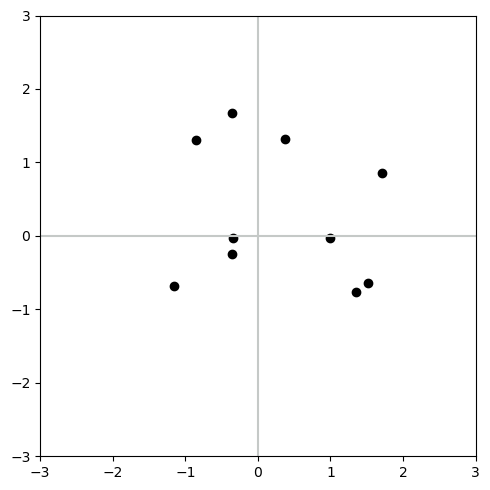

In [2]:
n_tr = 10
X_tr = rg.multivariate_normal(mean=np.zeros((2,)),
                              cov=np.eye(N=2),
                              size=(n_tr,))
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.axvline(x=0.0, color="xkcd:silver")
ax.axhline(y=0.0, color="xkcd:silver")
ax.scatter(X_tr[:,0], X_tr[:,1], marker="o", color="xkcd:black")
ax.set_xlim(left=-3.0, right=3.0)
ax.set_ylim(bottom=-3.0, top=3.0)
plt.tight_layout()
plt.show()

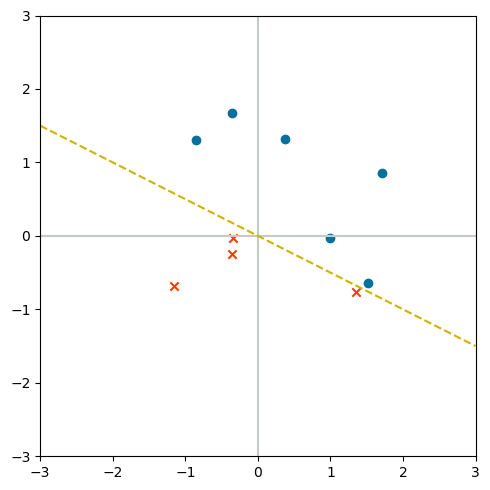

In [3]:
def linear_separator(X):
    '''
    真のラベルづけの規則
    '''
    w_0 = 0.0
    w_1 = 1.0
    w_2 = 2.0
    scores = w_1 * X[:,0] + w_2 * X[:,1] - w_0
    return np.where(scores <= 0, 0, 1)

def draw_line(x, w):
    '''
    ラベルづけ規則を可視化してくれる
    '''
    y = (w[0]/w[2]) - (w[1]/w[2]) * x
    return y


# ラベルたち
Y_tr = linear_separator(X=X_tr)

# ラベルを図示したプロット
fig, ax = plt.subplots(1, 1, figsize=(5,5))
idx_0 = Y_tr == 0
idx_1 = Y_tr == 1
ax.axvline(x=0.0, color="xkcd:silver")
ax.axhline(y=0.0, color="xkcd:silver")
ax.scatter(X_tr[idx_0,0], X_tr[idx_0,1], marker="x", color="xkcd:red orange")
ax.scatter(X_tr[idx_1,0], X_tr[idx_1,1], marker="o", color="xkcd:ocean blue")
line_horiz = np.linspace(-3, 3, 100)
line_vert = draw_line(x=line_horiz, w=np.array([0.0, 1.0, 2.0]))
ax.plot(line_horiz, line_vert, ls="dashed", color="xkcd:mustard")
ax.set_xlim(left=-3.0, right=3.0)
ax.set_ylim(bottom=-3.0, top=3.0)
plt.tight_layout()
plt.show()

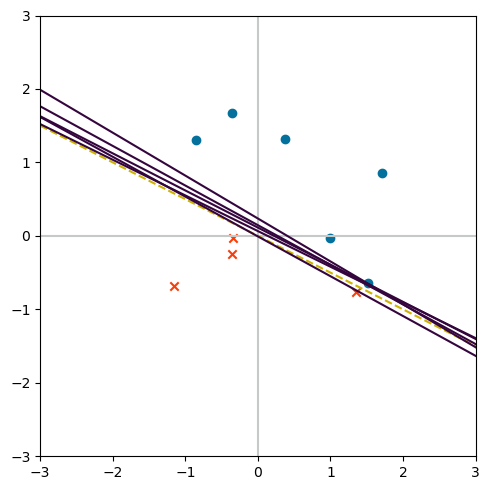

In [4]:
X_tr_padded = np.column_stack([-np.ones(shape=(len(X_tr),1)), X_tr])
num_runs = 5
candidate_list = []

# 指定された回数だけ実行して、学習の結果を保存しておく
for i in range(num_runs):

    # 初期化
    w_candidate = rg.uniform(low=-3, high=3, size=(3,))

    # 正誤を求める
    scores = w_candidate[1] * X_tr[:,0] + w_candidate[2] * X_tr[:,1] - w_candidate[0]
    labels = np.where(scores <= 0, 0, 1)
    losses_TF = labels != Y_tr
    losses_01 = np.where(losses_TF, 1, 0)
    num_wrong = losses_01.sum()
    
    # 全問正解でない限り更新していく
    while num_wrong > 0:
        idx_wrong = np.arange(len(X_tr))[losses_TF]
        idx = rg.choice(a=idx_wrong, size=1)
        x_wrong = X_tr_padded[idx,:].flatten() # 注意：ここだけpadded版を使う
        y_wrong = Y_tr[idx]
        if y_wrong == 1:
            sign_wrong = 1
        else:
            sign_wrong = -1 # 注意：ラベルは0と1だったための補正

        # 更新
        w_candidate += sign_wrong * x_wrong

        # 正誤を再び求める
        scores = w_candidate[1] * X_tr[:,0] + w_candidate[2] * X_tr[:,1] - w_candidate[0]
        labels = np.where(scores <= 0, 0, 1)
        losses_TF = labels != Y_tr
        losses_01 = np.where(losses_TF, 1, 0)
        num_wrong = losses_01.sum()
    
    candidate_list += [np.copy(w_candidate)]

# 学習結果を図示
fig, ax = plt.subplots(1, 1, figsize=(5,5))
idx_0 = Y_tr == 0
idx_1 = Y_tr == 1
ax.axvline(x=0.0, color="xkcd:silver")
ax.axhline(y=0.0, color="xkcd:silver")
ax.scatter(X_tr[idx_0,0], X_tr[idx_0,1], marker="x", color="xkcd:red orange")
ax.scatter(X_tr[idx_1,0], X_tr[idx_1,1], marker="o", color="xkcd:ocean blue")
line_horiz = np.linspace(-3, 3, 100)
line_vert = draw_line(x=line_horiz, w=np.array([0.0, 1.0, 2.0]))
ax.plot(line_horiz, line_vert, ls="dashed", color="xkcd:mustard")
for w_candidate in candidate_list:
    line_vert = draw_line(x=line_horiz, w=w_candidate)
    ax.plot(line_horiz, line_vert, ls="solid", color="xkcd:dark purple")
ax.set_xlim(left=-3.0, right=3.0)
ax.set_ylim(bottom=-3.0, top=3.0)
plt.tight_layout()
plt.show()

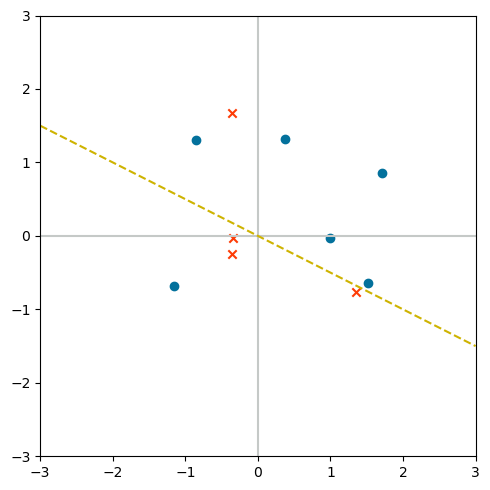

In [5]:
# ラベルを無作為に変更させる（＝ノイズ）
noise_rate = 0.2
Y_tr_noisy = np.copy(Y_tr)
idx_to_flip = rg.integers(low=0, high=len(Y_tr_noisy), size=max(1,int(noise_rate*len(Y_tr_noisy))))
Y_tr_noisy[idx_to_flip] = (Y_tr_noisy[idx_to_flip] + 1) % 2

# ラベルを図示したプロット
fig, ax = plt.subplots(1, 1, figsize=(5,5))
idx_0 = Y_tr_noisy == 0
idx_1 = Y_tr_noisy == 1
ax.axvline(x=0.0, color="xkcd:silver")
ax.axhline(y=0.0, color="xkcd:silver")
ax.scatter(X_tr[idx_0,0], X_tr[idx_0,1], marker="x", color="xkcd:red orange")
ax.scatter(X_tr[idx_1,0], X_tr[idx_1,1], marker="o", color="xkcd:ocean blue")
line_horiz = np.linspace(-3, 3, 100)
line_vert = draw_line(x=line_horiz, w=np.array([0.0, 1.0, 2.0]))
ax.plot(line_horiz, line_vert, ls="dashed", color="xkcd:mustard")
ax.set_xlim(left=-3.0, right=3.0)
ax.set_ylim(bottom=-3.0, top=3.0)
plt.tight_layout()
plt.show()

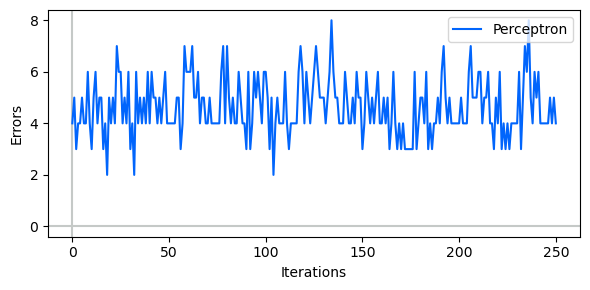

In [6]:
# 反復回数の上限を設ける
max_iterations = 250

# 初期化
w_candidate = rg.uniform(low=-3, high=3, size=(3,))

# 誤答数を記録するためのリスト
num_wrong_list = []

# 正誤を求める
scores = w_candidate[1] * X_tr[:,0] + w_candidate[2] * X_tr[:,1] - w_candidate[0]
labels = np.where(scores <= 0, 0, 1)
losses_TF = labels != Y_tr_noisy # 注意：ノイズあり
losses_01 = np.where(losses_TF, 1, 0)
num_wrong = losses_01.sum()
num_wrong_list += [num_wrong]

# パーセプトロンの実行（但し回数に上限あり）
for t in range(max_iterations):

    if num_wrong == 0:
        break

    else:
        idx_wrong = np.arange(len(X_tr))[losses_TF]
        idx = rg.choice(a=idx_wrong, size=1)
        x_wrong = X_tr_padded[idx,:].flatten()
        y_wrong = Y_tr_noisy[idx] # 注意：ノイズあり
        if y_wrong == 1:
            sign_wrong = 1
        else:
            sign_wrong = -1

        # 更新
        w_candidate += sign_wrong * x_wrong

        # 正誤を再び求める
        scores = w_candidate[1] * X_tr[:,0] + w_candidate[2] * X_tr[:,1] - w_candidate[0]
        labels = np.where(scores <= 0, 0, 1)
        losses_TF = labels != Y_tr_noisy # 注意：ノイズあり
        losses_01 = np.where(losses_TF, 1, 0)
        num_wrong = losses_01.sum()
        num_wrong_list += [num_wrong]

# 誤答数の推移を図示する
fig, ax = plt.subplots(1, 1, figsize=(6,3))
ax.axvline(x=0.0, color="xkcd:silver")
ax.axhline(y=0.0, color="xkcd:silver")
ax.plot(np.arange(0, len(num_wrong_list), 1), np.array(num_wrong_list),
        ls="solid", color="xkcd:bright blue", label="Perceptron")
plt.xlabel("Iterations")
plt.ylabel("Errors")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

## Hoeffdingの不等式の成否（ここからが本番）

同じデータに対して、別の側面を考える。まず、いくつかの候補をすでに持っているとする。どの候補も誤答数を算出することができる。以下の図では、候補たちを表示した上で、それぞれの損失分布（0 = 正解、1 = 不正解）のヒストグラムを示す（ヒストグラム内の垂直の破線の位置は平均値を表す）。

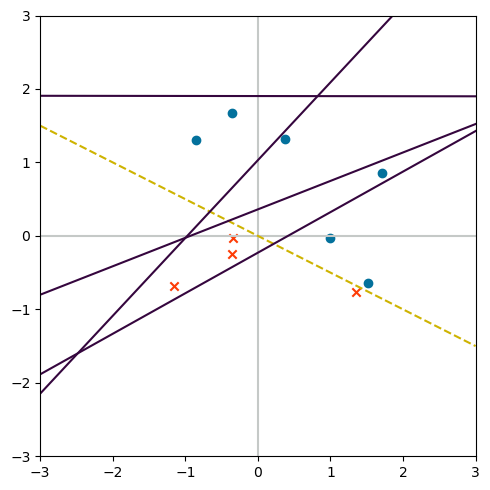

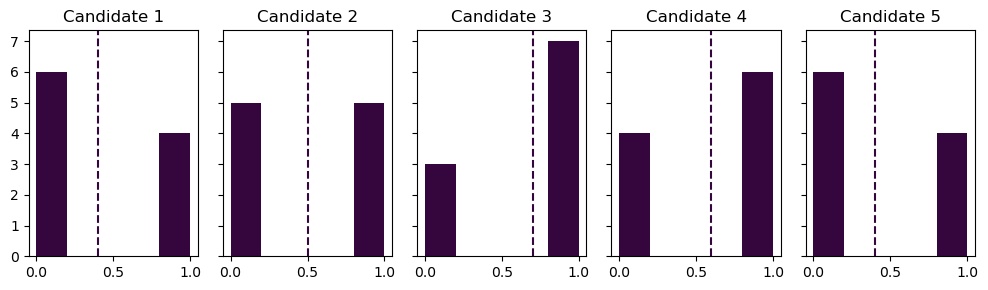

In [7]:
num_candidates = 5
candidate_list = []
losses_01_list = []

# 指定された候補数をランダムに生成して成績を算出する
for i in range(num_candidates):
    w_candidate = rg.uniform(low=-3, high=3, size=(3,))
    scores = w_candidate[1] * X_tr[:,0] + w_candidate[2] * X_tr[:,1] - w_candidate[0]
    labels = np.where(scores <= 0, 0, 1)
    losses_TF = labels != Y_tr
    losses_01 = np.where(losses_TF, 1, 0)
    candidate_list += [np.copy(w_candidate)]
    losses_01_list += [np.copy(losses_01)]

# 候補たちをプロットする
fig, ax = plt.subplots(1, 1, figsize=(5,5))
idx_0 = Y_tr == 0
idx_1 = Y_tr == 1
ax.axvline(x=0.0, color="xkcd:silver")
ax.axhline(y=0.0, color="xkcd:silver")
ax.scatter(X_tr[idx_0,0], X_tr[idx_0,1], marker="x", color="xkcd:red orange")
ax.scatter(X_tr[idx_1,0], X_tr[idx_1,1], marker="o", color="xkcd:ocean blue")
line_horiz = np.linspace(-3, 3, 100)
line_vert = draw_line(x=line_horiz, w=np.array([0.0, 1.0, 2.0]))
ax.plot(line_horiz, line_vert, ls="dashed", color="xkcd:mustard")
for w_candidate in candidate_list:
    line_vert = draw_line(x=line_horiz, w=w_candidate)
    ax.plot(line_horiz, line_vert, ls="solid", color="xkcd:dark purple")
ax.set_xlim(left=-3.0, right=3.0)
ax.set_ylim(bottom=-3.0, top=3.0)
plt.tight_layout()
plt.show()

# ゼロイチ誤差の分布をプロット
fig, axes = plt.subplots(1, num_candidates, figsize=(10,3), sharey=True)
for i, ax in enumerate(axes):
    losses_01 = np.where(losses_01_list[i], 1, 0)
    ax.hist(losses_01,
            bins="auto", color="xkcd:dark purple", ls="solid",
            fill=True, hatch=None, orientation="vertical", density=False)
    ax.set_title("Candidate {}".format(i+1))
    ax.axvline(x=losses_01.mean(), ls="dashed", color="xkcd:dark purple")
plt.tight_layout()
plt.show()

ここで各候補の損失分布のヒストグラムや損失の平均値を見れば、ある程度の良し悪しの見当がつく。いうまでもなく、機械学習では汎化能力が本質的に重要であるため、テストデータでの出来栄えを見ていきたい。

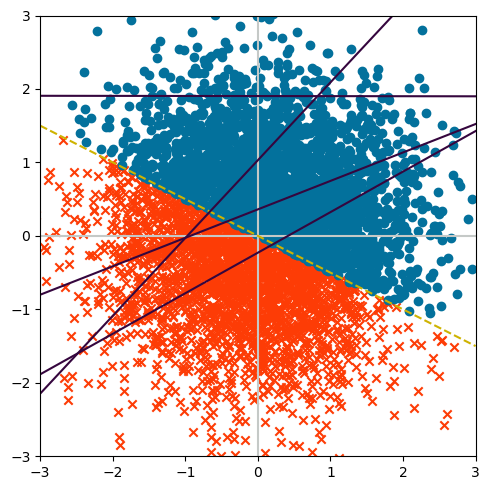

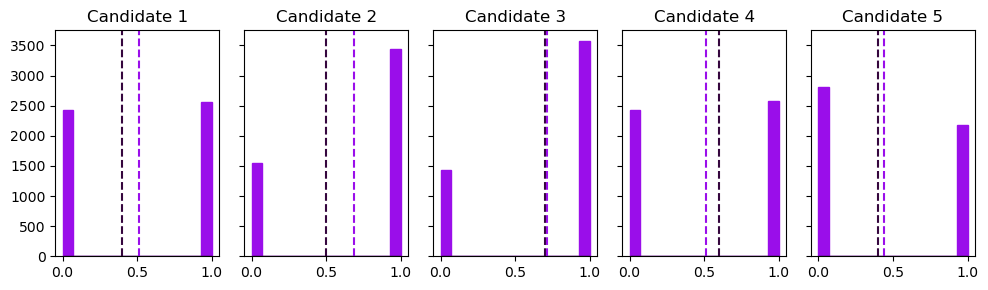

In [8]:
# テストデータを生成する
n_te = 5000
X_te = rg.multivariate_normal(mean=np.zeros((2,)),
                              cov=np.eye(N=2),
                              size=(n_te,))
Y_te = linear_separator(X=X_te)

# 候補たちを評価する
losses_01_te_list = []
for w_candidate in candidate_list:
    scores_te = w_candidate[1] * X_te[:,0] + w_candidate[2] * X_te[:,1] - w_candidate[0]
    labels_te = np.where(scores_te <= 0, 0, 1)
    losses_TF_te = labels_te != Y_te
    losses_01_te = np.where(losses_TF_te, 1, 0)
    losses_01_te_list += [np.copy(losses_01_te)]

# 候補たちをプロットする
fig, ax = plt.subplots(1, 1, figsize=(5,5))
idx_0 = Y_te == 0
idx_1 = Y_te == 1
ax.axvline(x=0.0, color="xkcd:silver")
ax.axhline(y=0.0, color="xkcd:silver")
ax.scatter(X_te[idx_0,0], X_te[idx_0,1], marker="x", color="xkcd:red orange")
ax.scatter(X_te[idx_1,0], X_te[idx_1,1], marker="o", color="xkcd:ocean blue")
line_horiz = np.linspace(-3, 3, 100)
line_vert = draw_line(x=line_horiz, w=np.array([0.0, 1.0, 2.0]))
ax.plot(line_horiz, line_vert, ls="dashed", color="xkcd:mustard")
for w_candidate in candidate_list:
    line_vert = draw_line(x=line_horiz, w=w_candidate)
    ax.plot(line_horiz, line_vert, ls="solid", color="xkcd:dark purple")
ax.set_xlim(left=-3.0, right=3.0)
ax.set_ylim(bottom=-3.0, top=3.0)
plt.tight_layout()
plt.show()

# ゼロイチ誤差の分布をプロット
fig, axes = plt.subplots(1, num_candidates, figsize=(10,3), sharey=True)
for i, ax in enumerate(axes):
    losses_01 = losses_01_list[i]
    losses_01_te = losses_01_te_list[i]
    ax.hist((losses_01, losses_01_te),
            bins="auto", color=("xkcd:dark purple", "xkcd:violet"), ls="solid", histtype="step",
            fill=True, hatch=None, orientation="vertical", density=False)
    ax.set_title("Candidate {}".format(i+1))
    ax.axvline(x=losses_01.mean(), ls="dashed", color="xkcd:dark purple")
    ax.axvline(x=losses_01_te.mean(), ls="dashed", color="xkcd:violet")
plt.tight_layout()
plt.show()

上図（ヒストグラム）の淡い紫色はテストデータでの成績を表している。候補によっては、標本平均（濃い紫色の破線）と真の誤答率（淡い紫色の破線）の差が大きかったり小さかったりするが、標本数とその差の関係は基本的にはHoeffdingの不等式が説明してくれる。上図はあくまで1つの試行（trial）だが、以下では複数の試行を独立に行い、学習アルゴリズムとHoeffdingの不等式の成否を確認していこう。

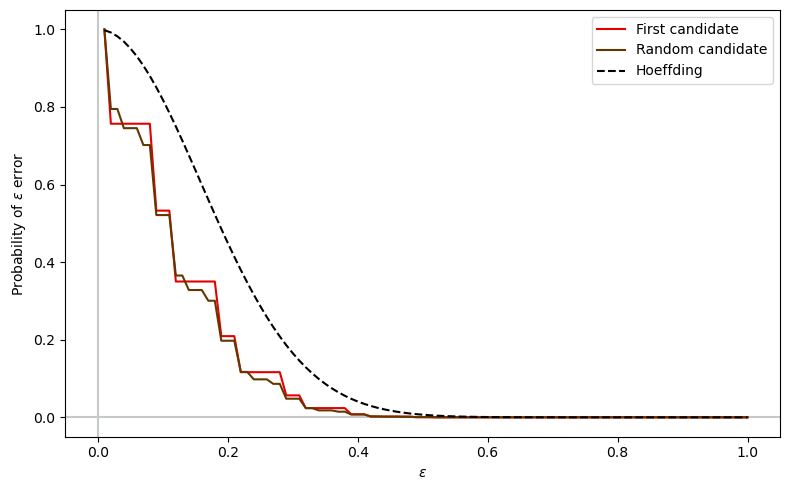

In [9]:
# テストデータでの平均損失を整えておく
loss_means_te = []
for losses_01_te in losses_01_te_list:
    loss_means_te += [losses_01_te.mean()]

num_trials = 50000
errors_0 = []
errors_random = []

# 複数の試行を独立に行う
for t in range(num_trials):

    # 学習データを新たに生成
    X_tr = rg.multivariate_normal(mean=np.zeros((2,)),
                                  cov=np.eye(N=2),
                                  size=(n_tr,))
    Y_tr = linear_separator(X=X_tr)
    
    # 候補たちを評価して期待損失の推定誤差を求める
    loss_means_tr = []
    errors = []
    for i, w_candidate in enumerate(candidate_list):
        scores_tr = w_candidate[1] * X_tr[:,0] + w_candidate[2] * X_tr[:,1] - w_candidate[0]
        labels_tr = np.where(scores_tr <= 0, 0, 1)
        losses_TF_tr = labels_tr != Y_tr
        losses_01_tr = np.where(losses_TF_tr, 1, 0)
        loss_means_tr += [losses_01_tr.mean()]
        errors += [np.absolute(losses_01_tr.mean() - loss_means_te[i])]
    loss_means_tr = np.array(loss_means_tr)
    idx_random = rg.integers(low=0, high=len(candidate_list), size=1).item()
    
    # 推定誤差を記録する
    errors_0 += [errors[0]]
    errors_random += [errors[idx_random]]

errors_0 = np.array(errors_0)
errors_random = np.array(errors_random)

# あとは誤差と発生確率の関係を図示する
epsilons =  np.linspace(start=0.01, stop=1.00, num=100)
hoeffding_bound = np.exp(-2*(epsilons**2)*n_tr)
probs_0 = []
probs_random = []
for i in range(len(epsilons)):
    epsilon = epsilons[i]
    probs_0 += [np.where(errors_0 > epsilon, 1, 0).mean()]
    probs_random += [np.where(errors_random > epsilon, 1, 0).mean()]

fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.axvline(x=0.0, color="xkcd:silver")
ax.axhline(y=0.0, color="xkcd:silver")
ax.plot(epsilons, probs_0,
        ls="solid", color="xkcd:red", label="First candidate")
ax.plot(epsilons, probs_random,
        ls="solid", color="xkcd:brown", label="Random candidate")
ax.plot(epsilons, hoeffding_bound,
        ls="dashed", color="xkcd:black", label="Hoeffding")
plt.xlabel(r"$\varepsilon$")
plt.ylabel(r"Probability of $\varepsilon$ error")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

上図では、横軸の実数値$\varepsilon$を取って、Bernoulli確率変数を前提としたHoeffdingの上界と、「標本平均損失とテスト平均損失の差が$\varepsilon$を超える」という事象の確率（複数試行に占める割合）を縦軸で表している。ランダムに選んだ候補や最初から固定した候補（ここでは1個目）に対しては、推定誤差が理論通りにHoeffdingの不等式に反していないことが確認できている。学習データを見ることなくこれらの候補を選んでいるので、Hoeffdingの前提条件である独立性が満たされており、当然の結果といえる。

次に、ラベルの分布を思い切ってノイジーなものにしても、同様の結果は確認できる。

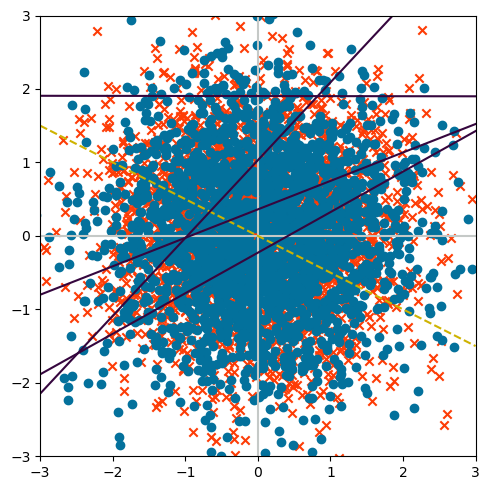

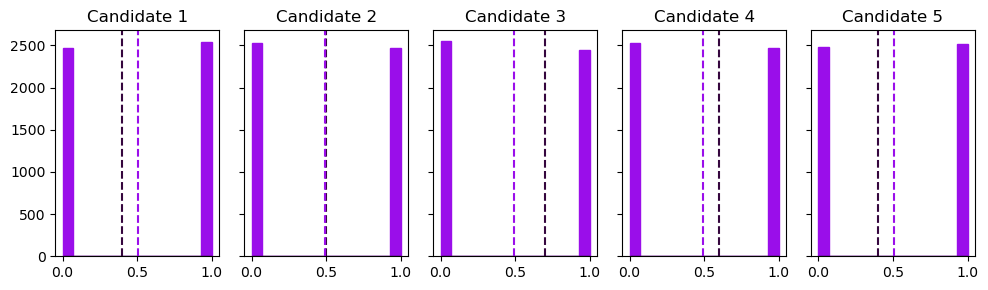

In [10]:
# テストデータの一部を書き換える
Y_te = rg.choice([0,1], size=(n_te,)) # 注意：ラベルは無作為

# 候補たちを評価する
losses_01_te_list = []
for w_candidate in candidate_list:
    scores_te = w_candidate[1] * X_te[:,0] + w_candidate[2] * X_te[:,1] - w_candidate[0]
    labels_te = np.where(scores_te <= 0, 0, 1)
    losses_TF_te = labels_te != Y_te
    losses_01_te = np.where(losses_TF_te, 1, 0)
    losses_01_te_list += [np.copy(losses_01_te)]

# 候補たちをプロットする
fig, ax = plt.subplots(1, 1, figsize=(5,5))
idx_0 = Y_te == 0
idx_1 = Y_te == 1
ax.axvline(x=0.0, color="xkcd:silver")
ax.axhline(y=0.0, color="xkcd:silver")
ax.scatter(X_te[idx_0,0], X_te[idx_0,1], marker="x", color="xkcd:red orange")
ax.scatter(X_te[idx_1,0], X_te[idx_1,1], marker="o", color="xkcd:ocean blue")
line_horiz = np.linspace(-3, 3, 100)
line_vert = draw_line(x=line_horiz, w=np.array([0.0, 1.0, 2.0]))
ax.plot(line_horiz, line_vert, ls="dashed", color="xkcd:mustard")
for w_candidate in candidate_list:
    line_vert = draw_line(x=line_horiz, w=w_candidate)
    ax.plot(line_horiz, line_vert, ls="solid", color="xkcd:dark purple")
ax.set_xlim(left=-3.0, right=3.0)
ax.set_ylim(bottom=-3.0, top=3.0)
plt.tight_layout()
plt.show()

# ゼロイチ誤差の分布をプロット
fig, axes = plt.subplots(1, num_candidates, figsize=(10,3), sharey=True)
for i, ax in enumerate(axes):
    losses_01 = losses_01_list[i]
    losses_01_te = losses_01_te_list[i]
    ax.hist((losses_01, losses_01_te),
            bins="auto", color=("xkcd:dark purple", "xkcd:violet"), ls="solid", histtype="step",
            fill=True, hatch=None, orientation="vertical", density=False)
    ax.set_title("Candidate {}".format(i+1))
    ax.axvline(x=losses_01.mean(), ls="dashed", color="xkcd:dark purple")
    ax.axvline(x=losses_01_te.mean(), ls="dashed", color="xkcd:violet")
plt.tight_layout()
plt.show()

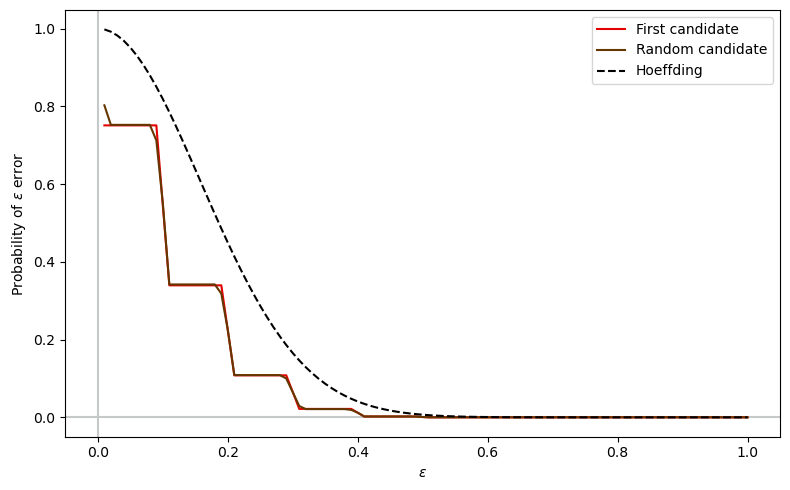

In [11]:
# テストデータでの平均損失を整えておく
loss_means_te = []
for losses_01_te in losses_01_te_list:
    loss_means_te += [losses_01_te.mean()]

errors_0 = []
errors_random = []

# 複数の試行を独立に行う
for t in range(num_trials):

    # 学習データを新たに生成
    X_tr = rg.multivariate_normal(mean=np.zeros((2,)),
                                  cov=np.eye(N=2),
                                  size=(n_tr,))
    Y_tr = rg.choice([0,1], size=(n_tr,)) # 注意：ラベルは無作為
    
    # 候補たちを評価して期待損失の推定誤差を求める
    loss_means_tr = []
    errors = []
    for i, w_candidate in enumerate(candidate_list):
        scores_tr = w_candidate[1] * X_tr[:,0] + w_candidate[2] * X_tr[:,1] - w_candidate[0]
        labels_tr = np.where(scores_tr <= 0, 0, 1)
        losses_TF_tr = labels_tr != Y_tr
        losses_01_tr = np.where(losses_TF_tr, 1, 0)
        loss_means_tr += [losses_01_tr.mean()]
        errors += [np.absolute(losses_01_tr.mean() - loss_means_te[i])]
    loss_means_tr = np.array(loss_means_tr)
    idx_random = rg.integers(low=0, high=len(candidate_list), size=1).item()
    
    # 推定誤差を記録する
    errors_0 += [errors[0]]
    errors_random += [errors[idx_random]]

errors_0 = np.array(errors_0)
errors_random = np.array(errors_random)

# あとは誤差と発生確率の関係を図示する
epsilons =  np.linspace(start=0.01, stop=1.00, num=100)
hoeffding_bound = np.exp(-2*(epsilons**2)*n_tr)
probs_0 = []
probs_random = []
for i in range(len(epsilons)):
    epsilon = epsilons[i]
    probs_0 += [np.where(errors_0 > epsilon, 1, 0).mean()]
    probs_random += [np.where(errors_random > epsilon, 1, 0).mean()]

fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.axvline(x=0.0, color="xkcd:silver")
ax.axhline(y=0.0, color="xkcd:silver")
ax.plot(epsilons, probs_0,
        ls="solid", color="xkcd:red", label="First candidate")
ax.plot(epsilons, probs_random,
        ls="solid", color="xkcd:brown", label="Random candidate")
ax.plot(epsilons, hoeffding_bound,
        ls="dashed", color="xkcd:black", label="Hoeffding")
plt.xlabel(r"$\varepsilon$")
plt.ylabel(r"Probability of $\varepsilon$ error")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

### 演習課題

__(3.1) Hoeffdingの成否__

上述のように学習データに依存しない手順（例：固定、無作為）で候補を選べば、Hoeffdingは成り立つ。しかし、学習アルゴリズムを実行する際、学習データを見てから候補を決めるので、損失値の独立性がなくなり、Hoeffdingの重要な前提条件が崩れる。

上図を参考に、"First candidate"と"Random candidate"に加えて、「学習時に最小の平均損失を持つ候補」「学習時に最大の平均損失を持つ候補」それぞれに対して推定誤差を記録し、$\varepsilon$の関数としての確率がHoeffdingに従うかどうかを検証すること。

さらに、ラベルのノイズの有無がどのように影響しているかを確認し、考察を述べること。